# Bunny
> Simulation

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연, 최규빈

In [321]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pygsp import graphs, filters, plotting, utils
import plotly.express as px
from IPython.display import HTML
import pandas as pd

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr
from plotly.subplots import make_subplots

import plotly.graph_objects as go

In [322]:
G = graphs.Bunny()
n = G.N

In [323]:
g = filters.Heat(G, tau=75) # 꼬리부분의 빨간신호를 퍼지게하는 정도

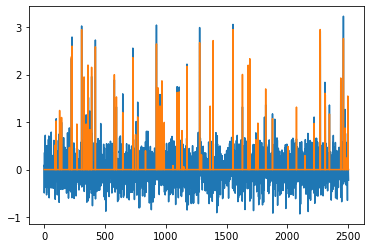

In [324]:
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif 
plt.plot(noise); plt.plot(unif)

In [325]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

2022-08-18 22:58:18,948:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


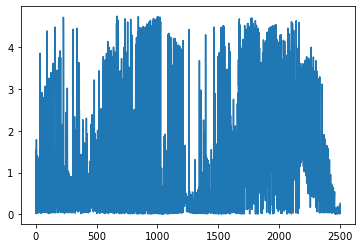

In [326]:
plt.plot(f)

In [327]:
W = G.W.toarray()
x = G.coords[:,0]
y = G.coords[:,1]
z = G.coords[:,2]

In [328]:
# fig = px.scatter_3d(x=x,y=y,z=z,
#                     color=f,
#                     opacity=0.7,
#                     height=400,
#                     size=abs(f+noise),
#                     range_color=[-1,5],
#                     color_continuous_scale='jet')
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.update_traces(marker=dict(line=dict(width=0)))
# HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [329]:
# fig = px.scatter_3d(x=x,y=y,z=z,
#                     color=f+noise,
#                     opacity=1,
#                     height=400,
#                     size=abs(f+noise),
#                     range_color=[-1,5],
#                     color_continuous_scale='jet')
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.update_traces(marker=dict(line=dict(width=0)))
# HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [330]:
df = pd.DataFrame({'x' : x, 'y' : y, 'z' : z, 'f' : f, 'noise' : noise})

In [506]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05
        
        fig, axs = plt.subplots(2,2,figsize=(16,16),subplot_kw={"projection":"3d"})
        axs[0,0].grid(False)
        axs[0,0].scatter3D(self.x,self.y,self.z,c=self.f,cmap='jet',zdir='z',s=50,marker='.',alpha=0.2)
        axs[0,0].set_title("f")
        axs[0,0].view_init(elev=30., azim=70)
        
        axs[0,1].grid(False)
        axs[0,1].scatter3D(self.x,self.y,self.z,c=self.fhat,zdir='z',cmap='jet',s=50,marker='.',alpha=0.2)
        axs[0,1].set_title("fhat")
        axs[0,1].view_init(elev=30., azim=70)
        
        axs[1,0].grid(False)
        axs[1,0].scatter3D(self.x,self.y,self.z,c=self.fnoise,cmap='jet',zdir='z',s=50,marker='.',alpha=0.2)
        axs[1,0].set_title("f+noise")
        axs[1,0].view_init(elev=30., azim=70)
        
        axs[1,1].grid(False)
        axs[1,1].scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['z'],c=self.df.query('Residual**2>@ref')['fnoise'],zdir='z',s=50,marker='.',alpha=1)
        axs[1,1].scatter3D(self.x,self.y,self.z,cmap='jet',c=self.fnoise,alpha=0.1,s=10)
        axs[1,1].set_title("residual")
        axs[1,1].view_init(elev=30., azim=70)
        
        
        plt.tight_layout()
        plt.show()
    def visf(self):
        fig = px.scatter_3d(x=self.x,y=self.y,z=self.z,
                    color=self.f,
                    opacity=1,
                    height=400,
                    size=abs(self.f),
                    range_color=[-1,5],
                    color_continuous_scale='jet')
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.update_traces(marker=dict(line=dict(width=0)))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    
    def visfhat(self):
        fig = px.scatter_3d(x=self.x,y=self.y,z=self.z,
                    color=self.fhat,
                    opacity=1,
                    height=400,
                    size=abs(self.fhat),
                    range_color=[-1,5],
                    color_continuous_scale='jet')
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.update_traces(marker=dict(line=dict(width=0)))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    
    def visfnoise(self):
        fig = px.scatter_3d(x=self.x,y=self.y,z=self.z,
                    color=self.fnoise,
                    opacity=1,
                    height=400,
                    size=abs(self.fnoise),
                    range_color=[-1,5],
                    color_continuous_scale='jet')
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.update_traces(marker=dict(line=dict(width=0)))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    
    def visres(self,ref=6):
        fig = px.scatter_3d(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'],z=self.df.query('Residual**2>@ref')['z'],
                    color=self.df.query('Residual**2>@ref')['f'],
                    opacity=1,
                    height=400,
                    size=abs(self.df.query('Residual**2>@ref')['f']),
                    range_color=[-1,5],
                    color_continuous_scale='jet')
        fig.add_scatter3d(x=self.x,y=self.y,z=self.z, mode="markers",marker=dict(size=3, color=self.f),name='f',opacity=0.1)
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.update_traces(marker=dict(line=dict(width=0)))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [507]:
_simul = SIMUL(df)

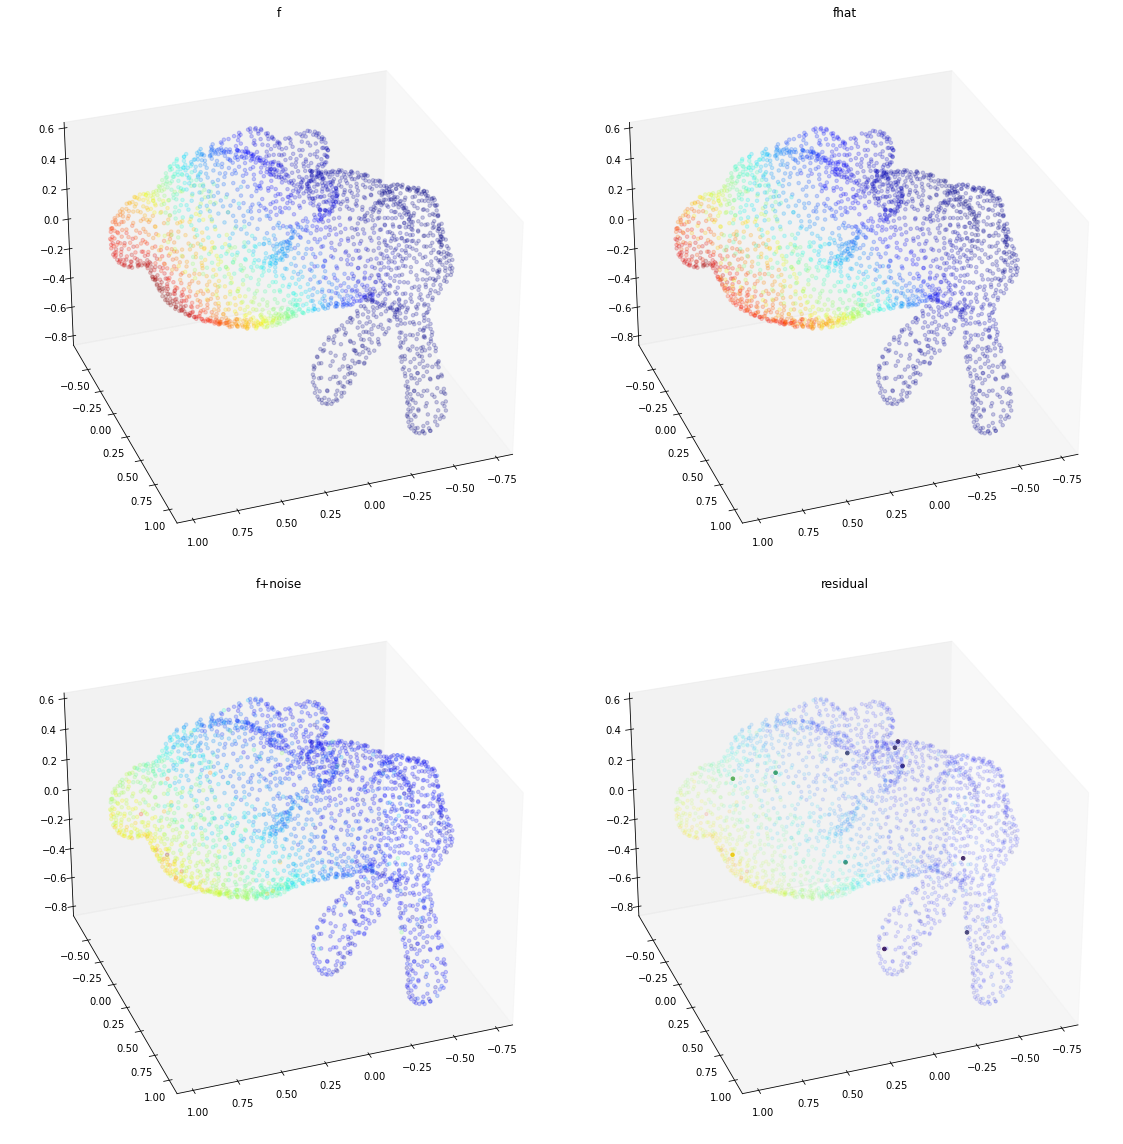

In [508]:
_simul.fit()

In [509]:
#_simul.visf()

In [465]:
#_simul.visfhat()

In [467]:
#_simul.visfnoise()

In [468]:
#_simul.visres()

In [462]:
_simul.df.query('Residual**2>10')

,x,y,z,f,noise,fnoise,fHat,Residual
2269,0.289944,-0.631817,0.042413,2.586924,2.920263,5.507187,2.291550,3.215637
2270,0.547602,-0.627568,0.053685,3.187828,2.904995,6.092823,2.792462,3.300361
2460,-0.383726,0.634205,-0.449411,0.039040,3.227903,3.266943,0.069439,3.197504
